In [8]:
import numpy as np
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import manifold, datasets
from sklearn.neighbors import NearestNeighbors

Automatically created module for IPython interactive environment


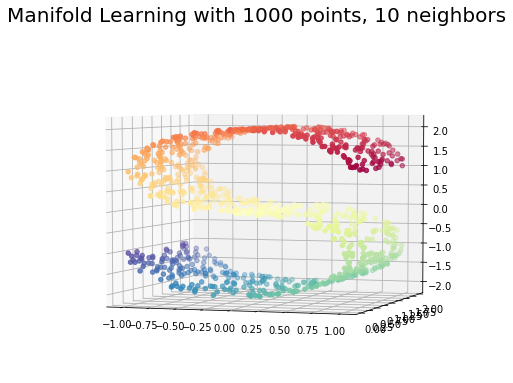

In [2]:
n_samples = 1000
n_components = 2
n_neighbors = 10

X, color = datasets.samples_generator.make_s_curve(n_samples, random_state=0)


fig = plt.figure(figsize=(8, 6))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=20)

raw_ax = fig.add_subplot(111, projection='3d')

raw_ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
raw_ax.view_init(4, -72)
plt.show()

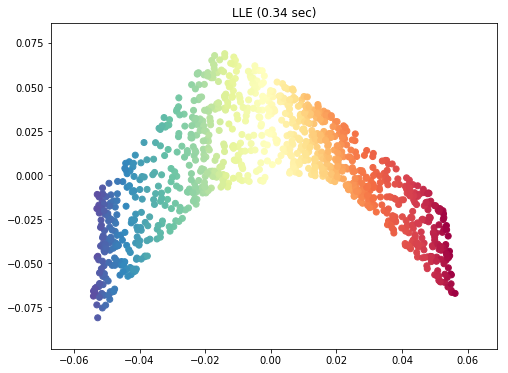

In [435]:
# LocallyLinearEmbedding

t0 = time()
Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                    eigen_solver='auto',
                                    method='standard').fit_transform(X)
t1 = time()

fig = plt.figure(figsize=(8, 6))

plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("%s (%.2g sec)" % ('LLE', t1 - t0))

plt.show()

In [424]:
# LLE: center and norm data first, no constraint to W -- FAILED

## 1. center and norm data first

def center_norm_X(X):
    X = X.astype(float)
    X = X - np.mean(X, axis=0)

    dim = X.shape[1]
    for d in range(dim):
        x = X[:, d]
        n = np.linalg.norm(x)
        x = x/n
        X[:, d] = x
    
    return X

X = center_norm_X(X)

In [436]:
# 2. find K-Nearest and cal W

def _matrixes_matmul(matrixes):
    result = None
    length = len(matrixes)
    
    if length <= 2:
        print('Use matmul instead')
        raise
    
    for i in range(length-2):
        matrix = matrixes[i]
        if result is None:
            result = np.identity(matrix.shape[0])
        result = np.matmul(result, matrix)
    
        matrix_next = matrixes[i+1]
        result = np.matmul(result, matrix_next)
    return result

In [452]:
def cal_W(X, n_neighbors=10):
    n_samples = X.shape[0]
    W_matrix = np.zeros(shape=(n_samples, n_samples))
    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(X)
    _, indices = nbrs.kneighbors(X)
    for i in indices:
        x_index = i[0]
        y_indices = i[1:]
        x = X[x_index]
        Y = X[y_indices]
        
        G = np.matmul(Y, Y.T)
        
        try:
            G_inv = np.linalg.inv(G)
        except:
            G_inv = np.linalg.pinv(G)
        w_val = _matrixes_matmul([x, Y.T, G_inv])
            
        np.put(W_matrix[x_index], y_indices, w_val)
    return W_matrix
        
W = cal_W(X, n_neighbors)

In [449]:
# 3. cal coordinates

I = np.identity(n_samples)
M = np.matmul(I - W.T, I - W)
eigvals, eigvects = np.linalg.eig(M)

keep_mask = np.greater(eigvals, 0)
eigvals_kept = eigvals[keep_mask]
eigvects_kept = eigvects[keep_mask]

eigvects_sorted = np.array([eigvect for _, eigvect in sorted(zip(eigvals_kept, eigvects_kept))])

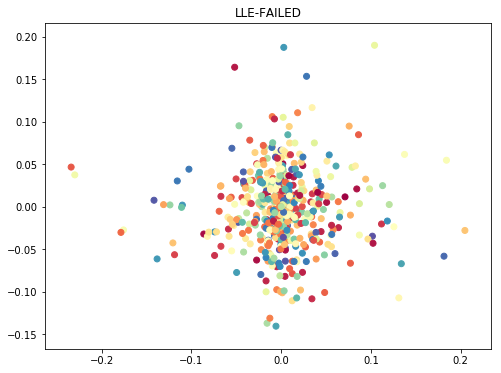

In [453]:
# 4. plot

y1 = eigvects_sorted[0]
y2 = eigvects_sorted[1]

fig = plt.figure(figsize=(8, 6))

plt.scatter(y1, y2, c=color, cmap=plt.cm.Spectral)
plt.title("LLE-FAILED")
plt.show()